# Book Recommendation System

## About Dataset
### Context

During the last few decades, with the rise of Youtube, Amazon, Netflix and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.
In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy or anything else depending on industries).

Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. As a proof of the importance of recommender systems, we can mention that, a few years ago, Netflix organised a challenges (the “Netflix prize”) where the goal was to produce a recommender system that performs better than its own algorithm with a prize of 1 million dollars to win.

By applying this simple dataset and related tasks and notebooks , we will evolutionary go through different paradigms of recommender algorithms . For each of them, we will present how they work, describe their theoretical basis and discuss their strengths and weaknesses.

Dataset Source: [Kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Users.csv)


The dataset consists of 3 separate CSV files for books, ratings and users. The goal is to find out the best recommendations for each user based on similar users' choices as well as previous choices made by the same user. These are Collaborative and Content-based filtering recommendation systems respectively that we are going to explore in this notebook.

Content
The Book-Crossing dataset comprises 3 files.

Users
Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.
Books
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.
Ratings
Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.
Starter Kernel(s)
Recom I: Data Understanding and Simple Recommendation
Acknowledgements
Collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

Inspiration
Based on following simple taxonomy of recommendation algorithms:

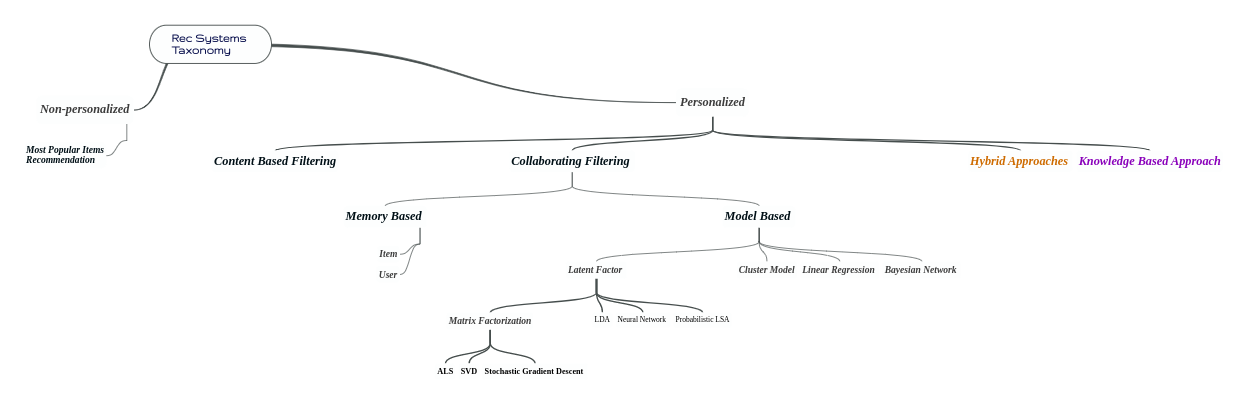


In [68]:
# conda install -c conda-forge scikit-surpriseZ


## Summary of Work
In this Notebook, the goal is to implement a recommender system based on the user's book ratings collected from 3 datasets of Books, Ratings and Users. The joined dataset has 1031136 records and Scikit-Surprise package is used to implement the recommendation system, implementing collaborative filtering.

In [69]:
## Import required packages
import pandas as pd 
import polars as pl
import numpy as np 
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy


In [70]:
books = pd.read_csv('Books.csv')
users = pd.read_csv('Users.csv')
ratings = pd.read_csv('Ratings.csv')
books.columns, users.columns,ratings.columns


/var/folders/f8/vxzlc3jn6_gfccykbxxydgww0000gn/T/ipykernel_67933/2001739384.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv')


(Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
        'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
       dtype='object'),
 Index(['User-ID', 'Location', 'Age'], dtype='object'),
 Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object'))

### Merging 3 tables into 1

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [51]:
books_user_ratings = books.merge(ratings,on='ISBN').merge(users, on='User-ID')
books_user_ratings = books_user_ratings[['User-ID', 'Book-Title', 'Book-Rating']]
books_user_ratings.shape

(1031136, 3)

In [4]:
books_user_ratings['Book-Rating'].value_counts()

0     647294
8      91804
10     71225
7      66402
9      60778
5      45355
6      31687
4       7617
3       5118
2       2375
1       1481
Name: Book-Rating, dtype: int64

### Removing 0 ratings from the dataset and take a smaller slice for computing limitations

In [26]:
books_user_ratings_1_10 = books_user_ratings[books_user_ratings['Book-Rating']!=0][:100000]

### Implementing the Recommender and train and test it on the dataset

In [27]:
# Define the reader
reader = Reader(rating_scale=(0, 10))

In [28]:
# Load the data using the reader
loaded_data = Dataset.load_from_df(books_user_ratings_1_10,reader)
# Split the data into training and testing sets
train_set, test_set = train_test_split(loaded_data, test_size=0.25)

In [29]:
# Use the k-NN algorithm for collaborative filtering
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)

# Train the model
model.fit(train_set)

# Make predictions on the test set
predictions = model.test(test_set)

# Evaluate the model
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.9324


1.9324326659953097

Below, you can run the trained model on random users to see what are the top-5 books that are recommended to the user. The `user_to_recommend` and `top_n` variables are adjustable.

In [61]:
import random
# Replace 1 with the actual user_id for which you want recommendations
user_to_recommend = random.choice(list(books_user_ratings_1_10['User-ID']))

# Get the books the user has not rated
user_items = books_user_ratings_1_10[books_user_ratings_1_10['User-ID'] == user_to_recommend]['Book-Title'].unique()
all_items = books_user_ratings_1_10['Book-Title'].unique()
items_to_recommend = np.setdiff1d(all_items, user_items)

# Generate recommendations for the user
predicted_ratings = [model.predict(user_to_recommend, item) for item in items_to_recommend]

# Sort the recommendations by predicted rating
recommendations = sorted(predicted_ratings, key=lambda x: x.est, reverse=True)

# Display the top N recommendations
top_n = 5
print("The User-ID is: ", user_to_recommend)
for i, recommendation in enumerate(recommendations[:top_n]):
    print(f"Rank {i+1}: Book {recommendation.iid} - Predicted Rating: {recommendation.est}")

The User-ID is:  35859
Rank 1: Book  Final Fantasy Anthology: Official Strategy Guide (Brady Games) - Predicted Rating: 10
Rank 2: Book  Q-Space (Star Trek The Next Generation, Book 47) - Predicted Rating: 10
Rank 3: Book  The Secret of the Old Clock (Nancy Drew, Book 1) - Predicted Rating: 10
Rank 4: Book 'California Historical Landmarks' - Predicted Rating: 10
Rank 5: Book 'Isms: a dictionary of words ending in -ism, -ology, and -phobia,: With some similar terms, arranged in subject order - Predicted Rating: 10
